In [1]:
from tqdm import tqdm
from etnn.nn.baseline import create_baseline_model, calc_params
import pandas as pd
import os
from sklearn.metrics import r2_score
from etnn.tools.training import train_epoch, eval_epoch
from etnn import TreeNode
from etnn.nn.layer_framework import LayerManagementFramework
from etnn.routines.run_config import choice_trainloader, choice_loss, choice_optim
import torch
from torch.utils.data import random_split, DataLoader
from etnn.data.ferris_wheel import load_pure_ferris_wheel_dataset_single_node
from etnn.tools.training_tools import ConfigStore, seeding_all
import matplotlib.pyplot as plt

In [2]:
dataset_path = "../../datasets/"
test_perc = 0.3
stability_count = 5
label = "tree-advanced" # although irrelevant

In [3]:
def create_plot(
        df,
        what: str = "r2"
) -> None:
    plt.figure()

    # Plot the initial data
    for config_id in df.config_id.unique():
        # make subdataset for config id
        sub_df = df[df.config_id == config_id]
        # plot train test and val
        for mode in ['train', 'test', 'val']:
            # plot training
            if f"{mode}_{what}" in sub_df.columns:
                plt.plot(sub_df.epoch, sub_df[f"{mode}_{what}"], label=f"{config_id}_{mode}-{what}")

    plt.title(f"{what} plot")
    plt.xlabel("epoch")
    plt.ylabel("score")
    if what == "r2":
        plt.ylim(-1, +1)
    elif what == "loss":
        plt.yscale('log')
    plt.legend()
    plt.show()

In [4]:
def run(i, entry, size_elem, normalized, node_type):
    # init default config
    config = ConfigStore(
        in_dim=15,
        hidden_dim=int(entry.params_hidden_dim),
        out_dim=1,
        k=int(entry.params_k),
        dataset=-1 if normalized else 0,
        ds_size=10_000,
        num_gondolas=-1,
        num_part_pg=-1,
        loss_name='mse',
        optimizer_name='adam',
        num_max_epochs=50, # 300, # real: 100
        learning_rate=float(entry.params_learning_rate),
        batch_size=1024,
        early_stop_tol=5,
        use_equal_batcher=bool(entry.params_batcher),
        seed=420,
        label_type=label,
        final_label_factor=5/1000
    )

    # loading dataset
    dataset, df_index = load_pure_ferris_wheel_dataset_single_node(
        node_type=node_type,
        num_elem=size_elem,
        num_to_generate=config.ds_size,
        dataset_path=dataset_path,
        final_label_factor=config.final_label_factor,
        normalize=True if config.dataset == -1 else 0
    )
    # splitting off test dataset
    generator = torch.Generator().manual_seed(config.seed)
    train_ds, test_ds= random_split(
        dataset,
        [1 - test_perc, test_perc],
        generator=generator
    )

    # loaders
    train_loader = choice_trainloader(config, df_index, train_ds)
    test_loader = DataLoader(test_ds, batch_size=4 * config.batch_size, shuffle=False)

    # define device
    device = "cuda" if torch.cuda.is_available() else "cpu"

    # set seed for reproducability
    seeding_all(config.seed)

    # define model
    model = LayerManagementFramework(
        in_dim=config.in_dim,
        tree=TreeNode(node_type, [TreeNode("E", size_elem)]),
        hidden_dim=config.hidden_dim,
        out_dim=config.out_dim,
        k=config.k
    ).to(device)
    print(f"Model params etnn: {calc_params(model)}")

    # learning tools
    criterion = choice_loss(config)
    optimizer = choice_optim(config, model)

    # init score list
    train_r2_list = []
    test_r2_list = []
    train_loss_list = []
    test_loss_list = []

    file_name = f"csvs/single-node_node-type-{node_type}_rank-{i}_normalized-{normalized}_n-{size_elem}.csv"
    if os.path.isfile(file_name):
        df = pd.read_csv(file_name)
    else:
        # train for specified number of epochs
        for epoch in tqdm(range(config.num_max_epochs)):
            train_loss, train_true_y, train_pred_y = train_epoch(
                model,
                train_loader,
                optimizer,
                device,
                criterion
            )

            test_loss, test_true_y, test_pred_y = eval_epoch(
                model,
                test_loader,
                device,
                criterion
            )

            # calc r2 score and append
            train_r2_list += [r2_score(y_true=train_true_y, y_pred=train_pred_y)]
            test_r2_list += [r2_score(y_true=test_true_y, y_pred=test_pred_y)]
            train_loss_list += [train_loss.item()]
            test_loss_list += [test_loss.item()]

        # REPEAT FOR BASELINE MODEL
        seeding_all(config.seed)
        # %%
        model, _ = create_baseline_model(
            n_params=calc_params(model),
            input_dim=config.in_dim * size_elem,
            n_layer=3,
            output_dim=1
        )
        model = model.to(device)

        optimizer = choice_optim(config, model)

        # train for N epochs
        for epoch in tqdm(range(config.num_max_epochs)):
            train_loss, train_true_y, train_pred_y = train_epoch(
                model,
                train_loader,
                optimizer,
                device,
                criterion
            )

            test_loss, test_true_y, test_pred_y = eval_epoch(
                model,
                test_loader,
                device,
                criterion
            )

            # calc r2 score and append
            train_r2_list += [r2_score(y_true=train_true_y, y_pred=train_pred_y)]
            test_r2_list += [r2_score(y_true=test_true_y, y_pred=test_pred_y)]
            train_loss_list += [train_loss.item()]
            test_loss_list += [test_loss.item()]

        df = pd.DataFrame({
            "config_id": ["etnn"]*config.num_max_epochs + ["baseline"]*config.num_max_epochs,
            "epoch": list(range(1, config.num_max_epochs + 1))*2,
            "train_loss": train_loss_list,
            "test_loss": test_loss_list,
            "train_r2": train_r2_list,
            "test_r2": test_r2_list
        })
        df.to_csv(file_name)

    # plotting
    create_plot(df, "r2")
    create_plot(df, "loss")

# S

Rank 1 parameter configuration: Unnamed: 0                                      12
number                                          12
value                                     0.967211
datetime_start          2023-12-20 21:39:12.951175
datetime_complete       2023-12-20 21:40:27.807221
duration                    0 days 00:01:14.856046
params_batcher                                True
params_hidden_dim                               16
params_k                                         1
params_learning_rate                      0.009973
state                                     COMPLETE
Name: 12, dtype: object
Model params etnn: 977


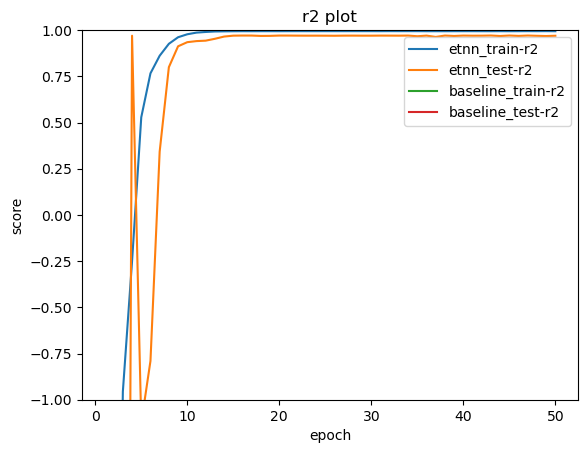

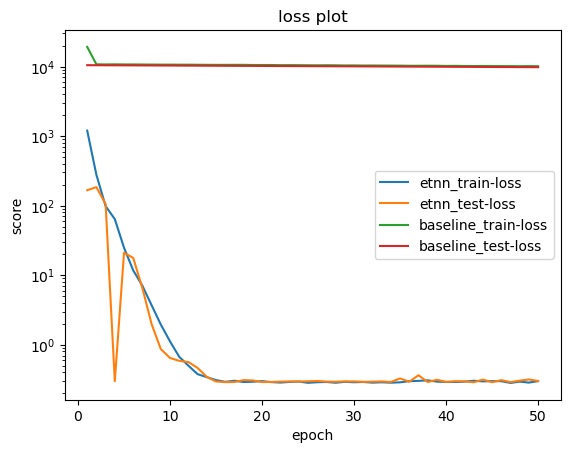

Rank 2 parameter configuration: Unnamed: 0                                      21
number                                          21
value                                     0.967148
datetime_start          2023-12-20 21:51:07.457498
datetime_complete       2023-12-20 21:52:34.525252
duration                    0 days 00:01:27.067754
params_batcher                                True
params_hidden_dim                               16
params_k                                         1
params_learning_rate                      0.009959
state                                     COMPLETE
Name: 21, dtype: object
Model params etnn: 977


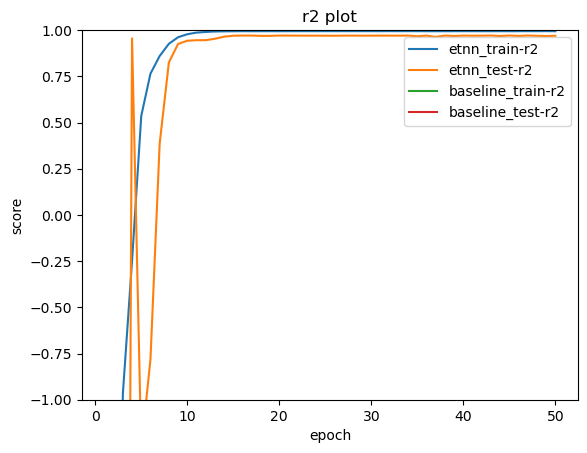

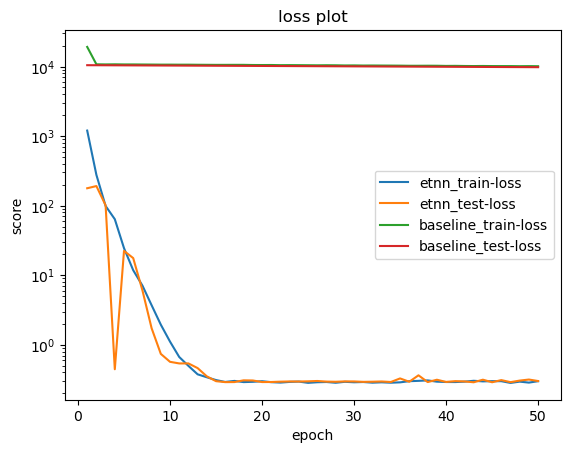

Rank 3 parameter configuration: Unnamed: 0                                      22
number                                          22
value                                     0.967013
datetime_start          2023-12-20 21:52:34.526257
datetime_complete       2023-12-20 21:54:08.329067
duration                    0 days 00:01:33.802810
params_batcher                                True
params_hidden_dim                               16
params_k                                         1
params_learning_rate                      0.004911
state                                     COMPLETE
Name: 22, dtype: object
Model params etnn: 977


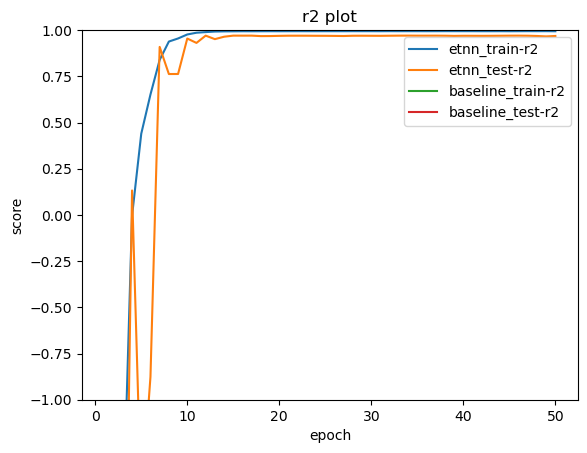

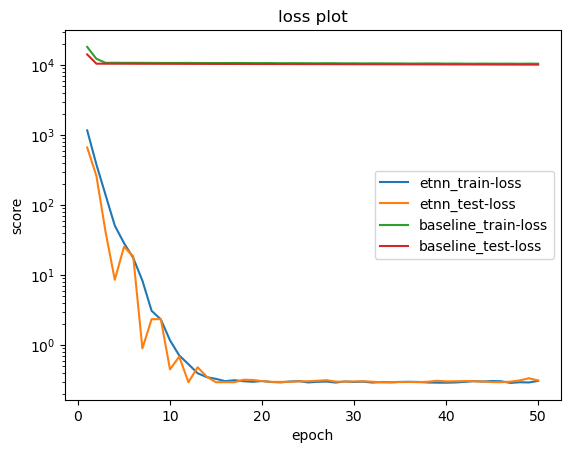

In [5]:
normalized = False
size_elem = 50
node_type = "S"

config_table = pd.read_csv(f"csvs/single-node_t-{node_type}_n-{size_elem}_normalized-{normalized}_s-{size_elem}.csv")

# sort config storage
config_table = config_table.sort_values(by=['value'], ascending=False)

# iterate over top 3 best configs
for i in range(3):
    # get entry from dataframe
    entry = config_table.iloc[i]

    # print information to console
    print(f"Rank {i+1} parameter configuration: {entry}")

    run(i, entry, size_elem, normalized, node_type)

Rank 1 parameter configuration: Unnamed: 0                                      15
number                                          15
value                                     0.967496
datetime_start          2023-12-20 22:20:19.527050
datetime_complete       2023-12-20 22:21:50.860978
duration                    0 days 00:01:31.333928
params_batcher                               False
params_hidden_dim                              368
params_k                                         3
params_learning_rate                      0.004579
state                                     COMPLETE
Name: 15, dtype: object
Model params etnn: 634065


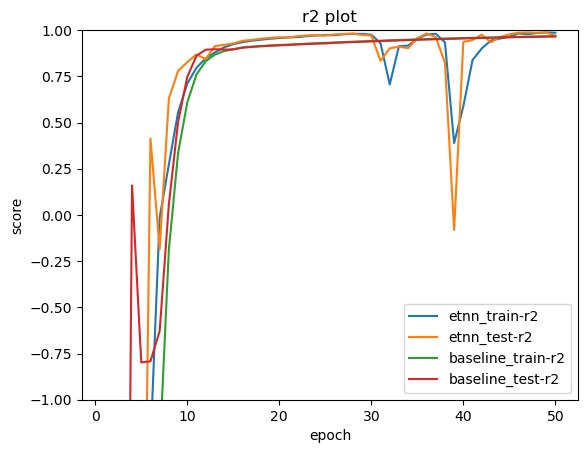

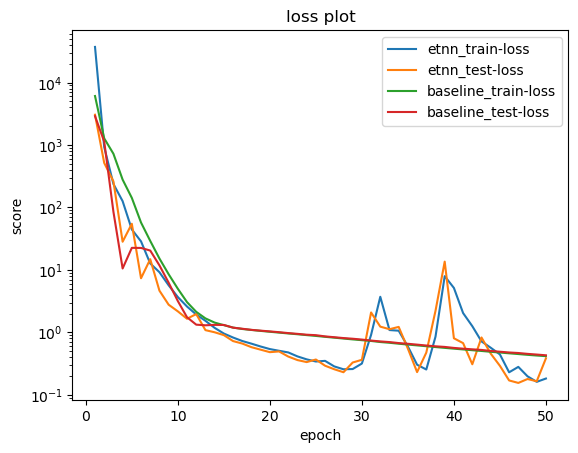

Rank 2 parameter configuration: Unnamed: 0                                      14
number                                          14
value                                     0.943993
datetime_start          2023-12-20 22:18:49.173177
datetime_complete       2023-12-20 22:20:19.526049
duration                    0 days 00:01:30.352872
params_batcher                               False
params_hidden_dim                              384
params_k                                         3
params_learning_rate                      0.003645
state                                     COMPLETE
Name: 14, dtype: object
Model params etnn: 690049


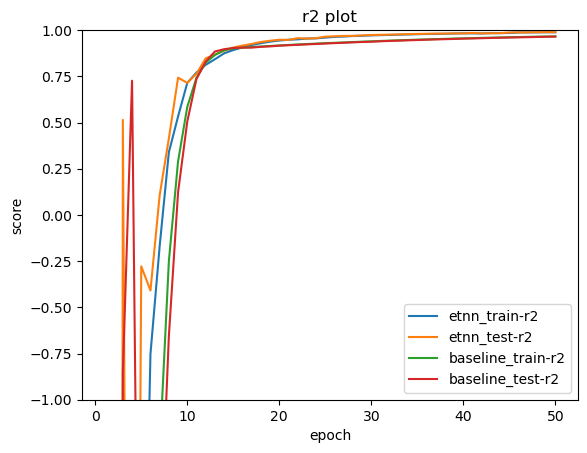

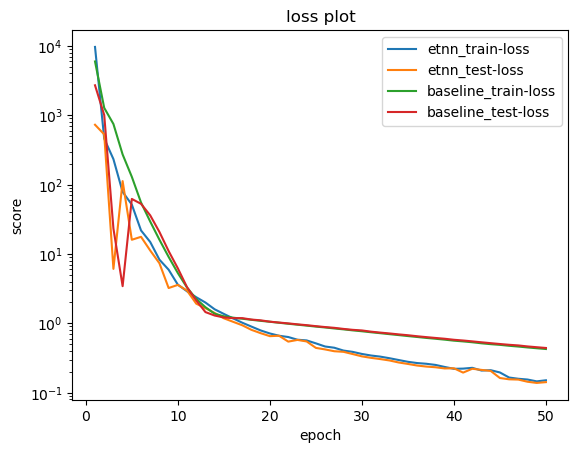

Rank 3 parameter configuration: Unnamed: 0                                      11
number                                          11
value                                     0.936679
datetime_start          2023-12-20 22:14:17.134755
datetime_complete       2023-12-20 22:15:50.972197
duration                    0 days 00:01:33.837442
params_batcher                                True
params_hidden_dim                              512
params_k                                         2
params_learning_rate                      0.001495
state                                     COMPLETE
Name: 11, dtype: object
Model params etnn: 960513


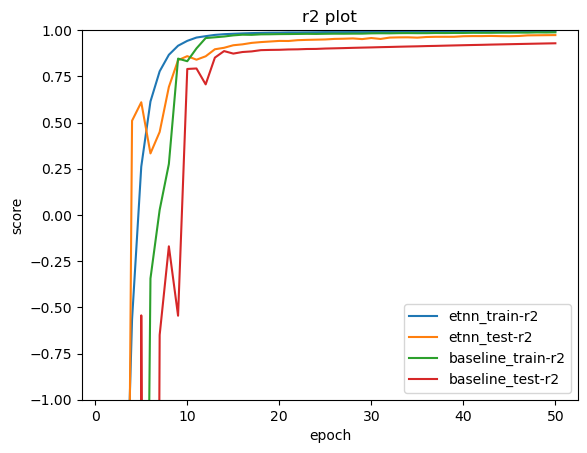

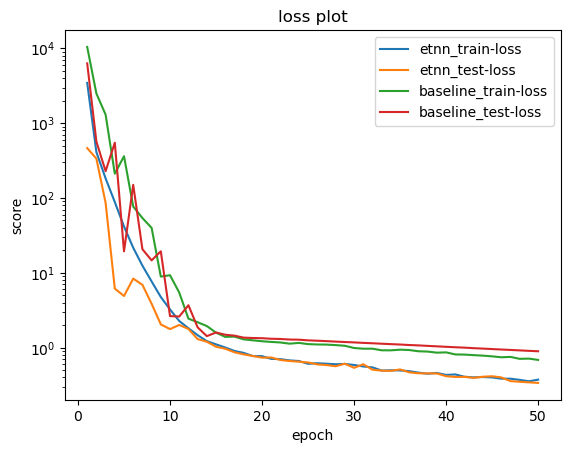

In [6]:
normalized = True
size_elem = 50
node_type = "S"

config_table = pd.read_csv(f"csvs/single-node_t-{node_type}_n-{size_elem}_normalized-{normalized}_s-{size_elem}.csv")

# sort config storage
config_table = config_table.sort_values(by=['value'], ascending=False)

# iterate over top 3 best configs
for i in range(3):
    # get entry from dataframe
    entry = config_table.iloc[i]

    # print information to console
    print(f"Rank {i+1} parameter configuration: {entry}")

    run(i, entry, size_elem, normalized, node_type)

# Q

Rank 1 parameter configuration: Unnamed: 0                                      11
number                                          11
value                                     0.949304
datetime_start          2023-12-20 22:54:43.276181
datetime_complete       2023-12-20 22:56:11.468440
duration                    0 days 00:01:28.192259
params_batcher                               False
params_hidden_dim                               96
params_k                                         4
params_learning_rate                      0.007033
state                                     COMPLETE
Name: 11, dtype: object
Model params etnn: 53953


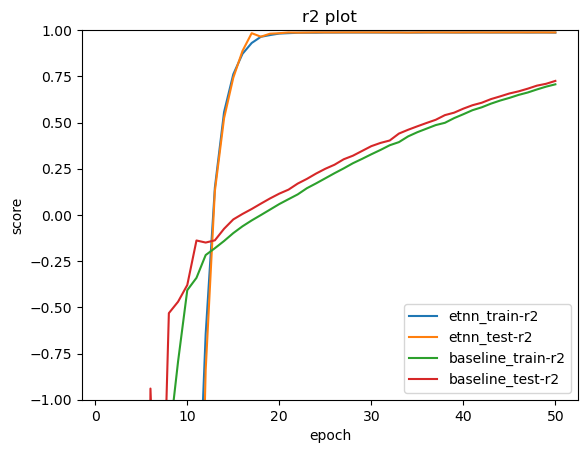

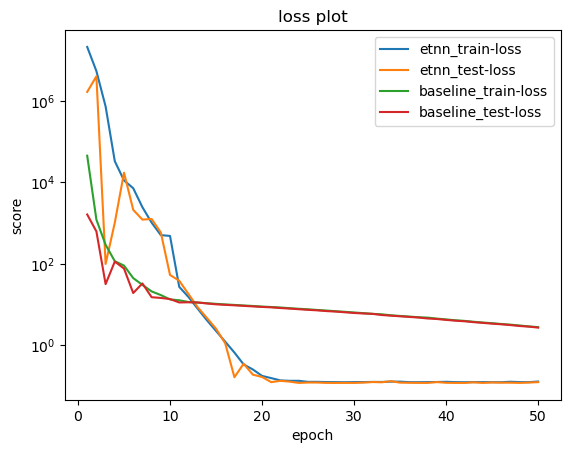

Rank 2 parameter configuration: Unnamed: 0                                      18
number                                          18
value                                     0.943348
datetime_start          2023-12-20 23:06:09.294407
datetime_complete       2023-12-20 23:07:49.753505
duration                    0 days 00:01:40.459098
params_batcher                                True
params_hidden_dim                              224
params_k                                         4
params_learning_rate                      0.002236
state                                     COMPLETE
Name: 18, dtype: object
Model params etnn: 287169


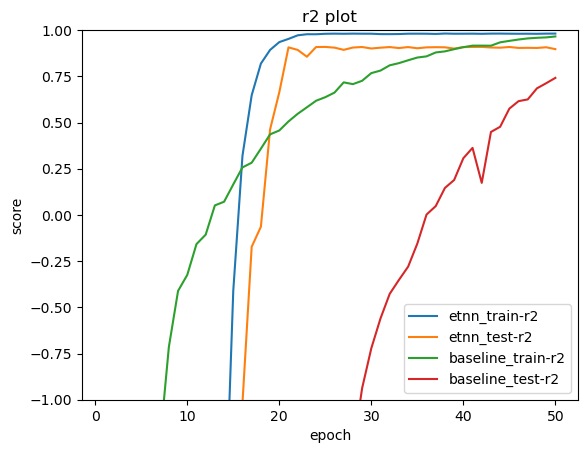

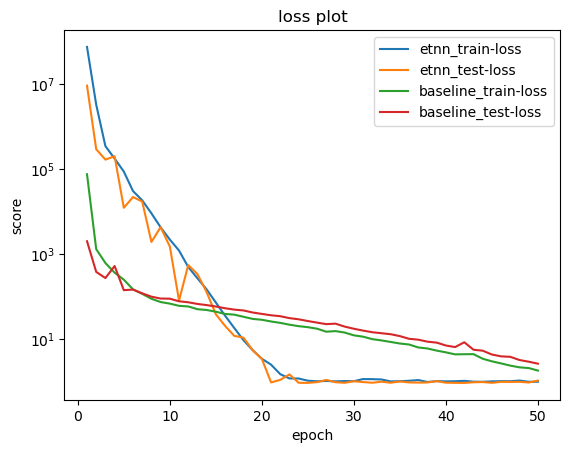

Rank 3 parameter configuration: Unnamed: 0                                      17
number                                          17
value                                     0.922773
datetime_start          2023-12-20 23:04:33.813665
datetime_complete       2023-12-20 23:06:09.293406
duration                    0 days 00:01:35.479741
params_batcher                                True
params_hidden_dim                              256
params_k                                         3
params_learning_rate                      0.005028
state                                     COMPLETE
Name: 17, dtype: object
Model params etnn: 308481


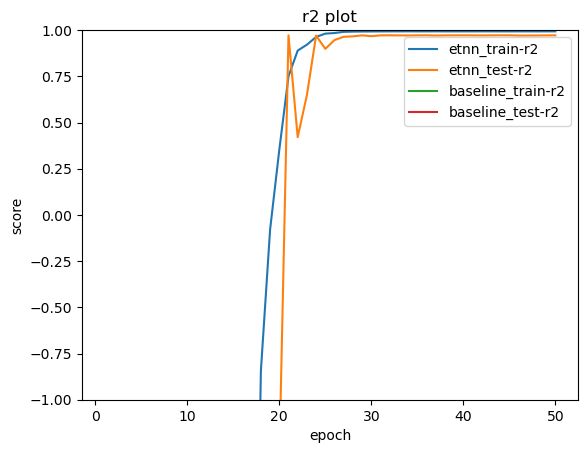

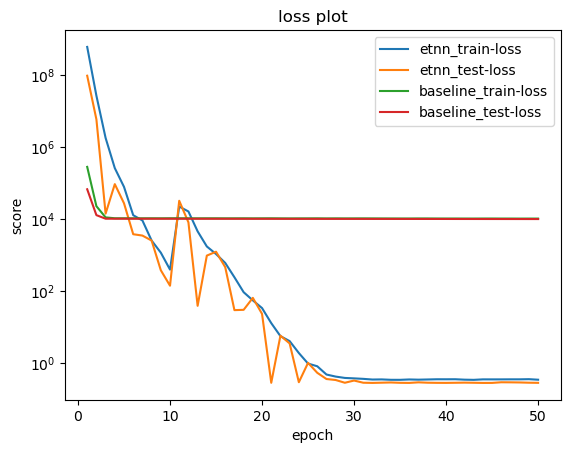

In [7]:
normalized = False
size_elem = 50
node_type = "Q"

config_table = pd.read_csv(f"csvs/single-node_t-{node_type}_n-{size_elem}_normalized-{normalized}_s-{size_elem}.csv")

# sort config storage
config_table = config_table.sort_values(by=['value'], ascending=False)

# iterate over top 3 best configs
for i in range(3):
    # get entry from dataframe
    entry = config_table.iloc[i]

    # print information to console
    print(f"Rank {i+1} parameter configuration: {entry}")

    run(i, entry, size_elem, normalized, node_type)

Rank 1 parameter configuration: Unnamed: 0                                       1
number                                           1
value                                     0.959886
datetime_start          2023-12-20 23:18:49.644504
datetime_complete       2023-12-20 23:20:14.674870
duration                    0 days 00:01:25.030366
params_batcher                               False
params_hidden_dim                              336
params_k                                         2
params_learning_rate                      0.005312
state                                     COMPLETE
Name: 1, dtype: object
Model params etnn: 415969


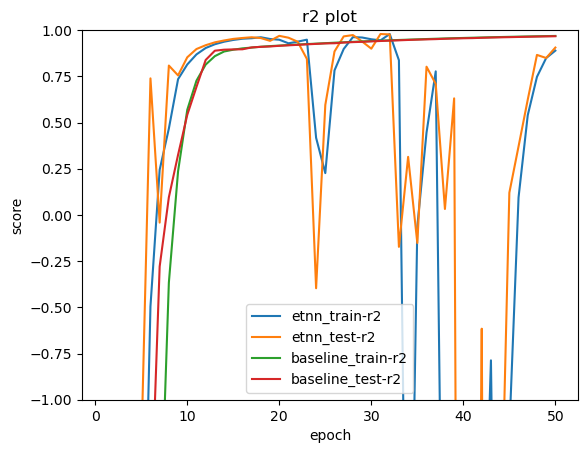

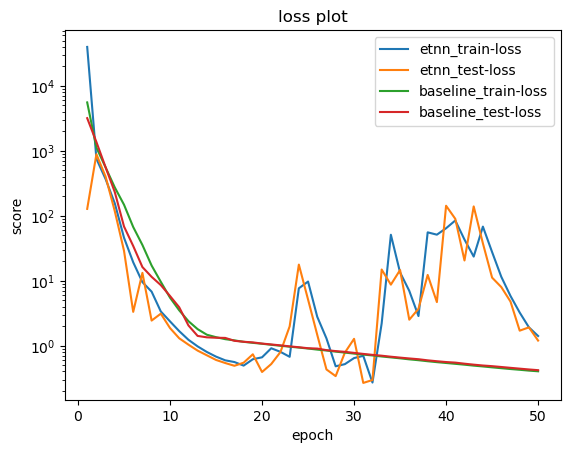

Rank 2 parameter configuration: Unnamed: 0                                      11
number                                          11
value                                     0.959165
datetime_start          2023-12-20 23:38:56.249952
datetime_complete       2023-12-20 23:41:19.934543
duration                    0 days 00:02:23.684591
params_batcher                                True
params_hidden_dim                              368
params_k                                         2
params_learning_rate                      0.009672
state                                     COMPLETE
Name: 11, dtype: object
Model params etnn: 498273


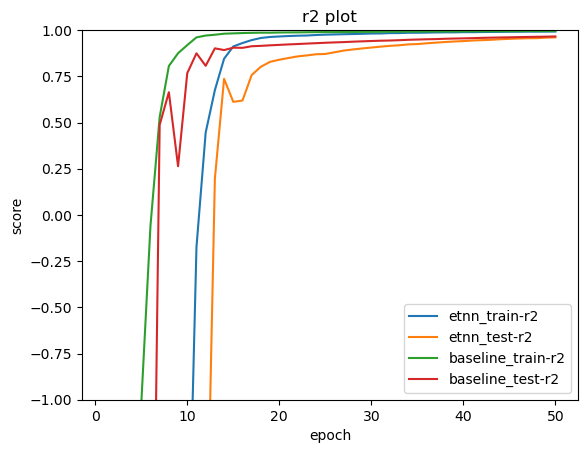

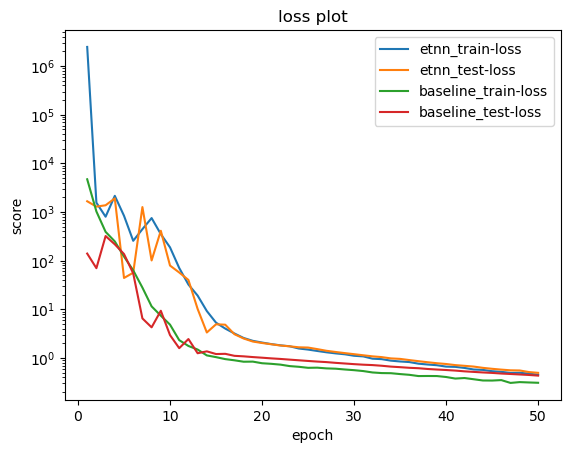

Rank 3 parameter configuration: Unnamed: 0                                      21
number                                          21
value                                     0.938171
datetime_start          2023-12-21 00:00:38.623182
datetime_complete       2023-12-21 00:02:45.937988
duration                    0 days 00:02:07.314806
params_batcher                                True
params_hidden_dim                              304
params_k                                         2
params_learning_rate                      0.005283
state                                     COMPLETE
Name: 21, dtype: object
Model params etnn: 341089


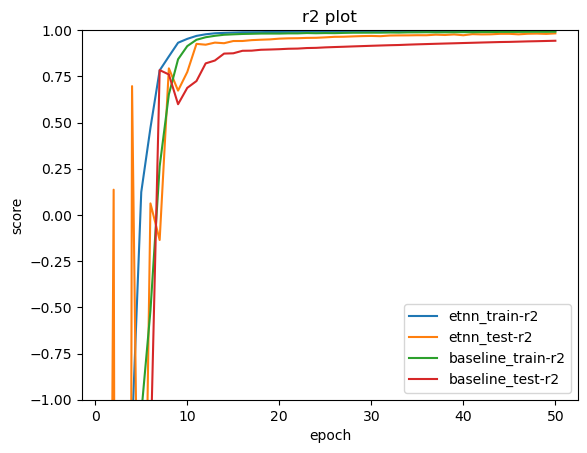

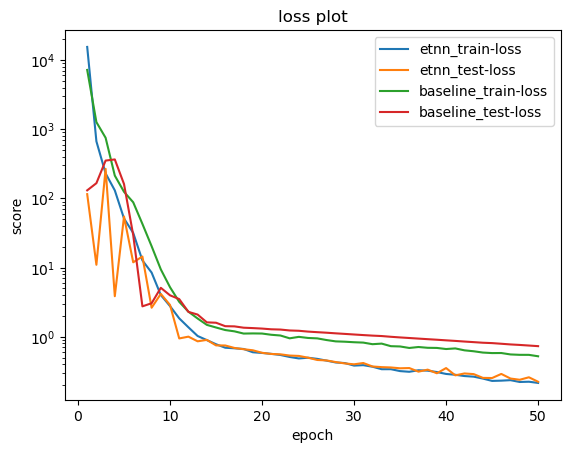

In [8]:
normalized = True
size_elem = 50
node_type = "Q"

config_table = pd.read_csv(f"csvs/single-node_t-{node_type}_n-{size_elem}_normalized-{normalized}_s-{size_elem}.csv")

# sort config storage
config_table = config_table.sort_values(by=['value'], ascending=False)

# iterate over top 3 best configs
for i in range(3):
    # get entry from dataframe
    entry = config_table.iloc[i]

    # print information to console
    print(f"Rank {i+1} parameter configuration: {entry}")

    run(i, entry, size_elem, normalized, node_type)

# C

Rank 1 parameter configuration: Unnamed: 0                                      11
number                                          11
value                                     0.991024
datetime_start          2023-12-21 00:39:31.386376
datetime_complete       2023-12-21 00:41:40.694401
duration                    0 days 00:02:09.308025
params_batcher                               False
params_hidden_dim                              368
params_k                                         1
params_learning_rate                      0.000301
state                                     COMPLETE
Name: 11, dtype: object
Model params etnn: 362481


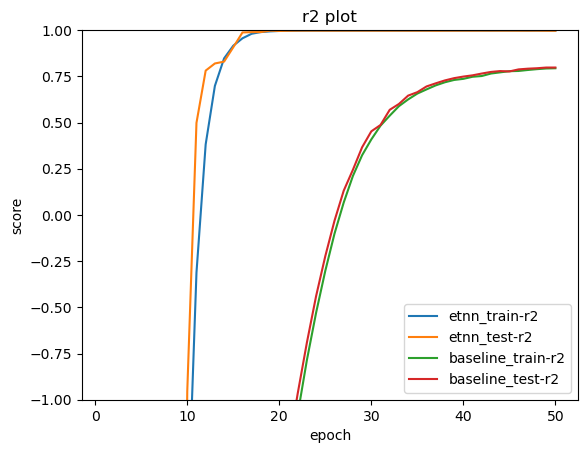

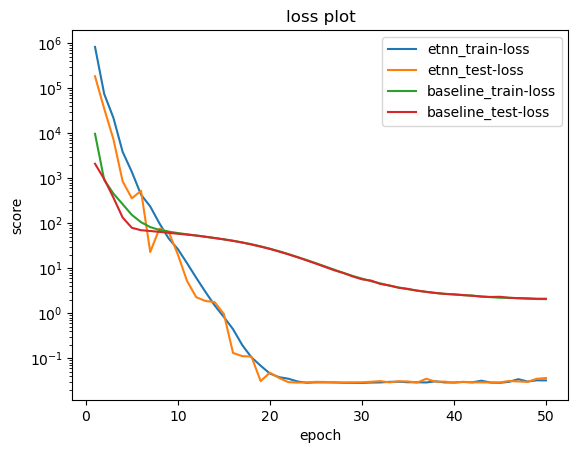

Rank 2 parameter configuration: Unnamed: 0                                      23
number                                          23
value                                     0.980641
datetime_start          2023-12-21 01:11:30.195734
datetime_complete       2023-12-21 01:13:39.731663
duration                    0 days 00:02:09.535929
params_batcher                               False
params_hidden_dim                              288
params_k                                         1
params_learning_rate                      0.000203
state                                     COMPLETE
Name: 23, dtype: object
Model params etnn: 223201


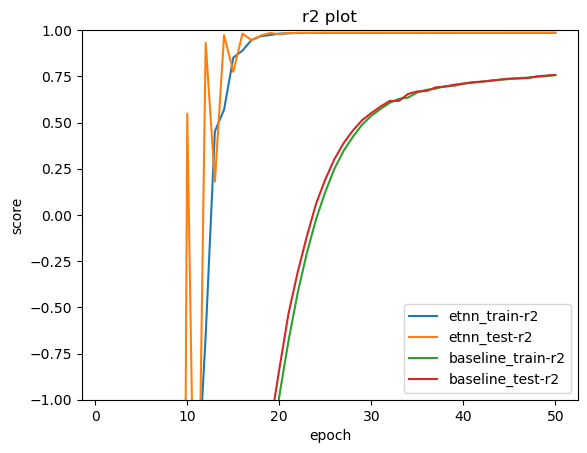

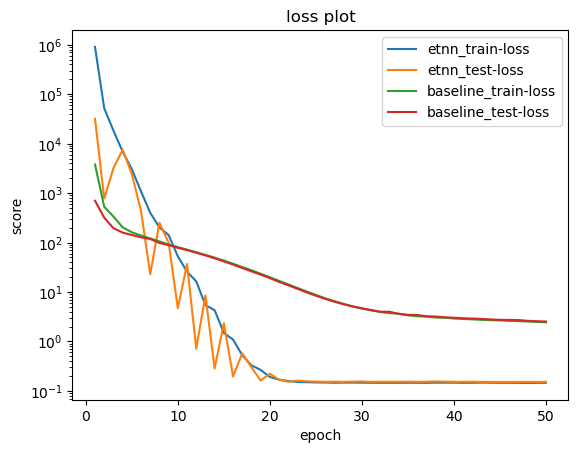

Rank 3 parameter configuration: Unnamed: 0                                      21
number                                          21
value                                     0.977433
datetime_start          2023-12-21 01:07:07.846646
datetime_complete       2023-12-21 01:09:20.933997
duration                    0 days 00:02:13.087351
params_batcher                               False
params_hidden_dim                              368
params_k                                         1
params_learning_rate                      0.000231
state                                     COMPLETE
Name: 21, dtype: object
Model params etnn: 362481


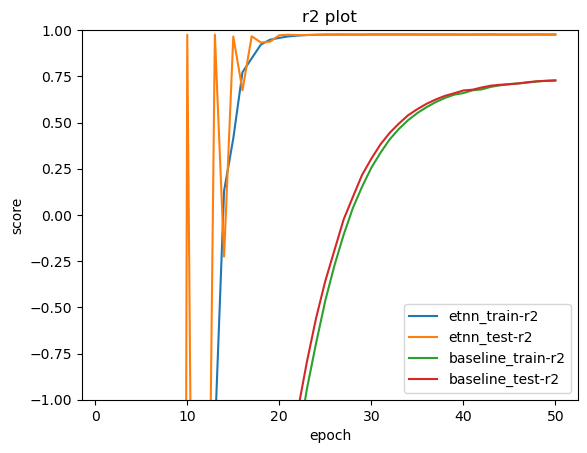

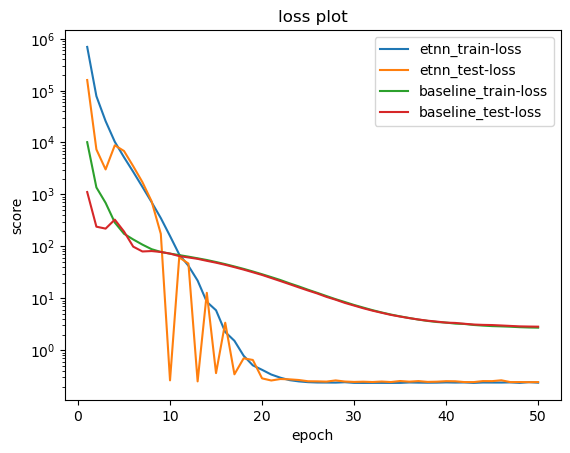

In [9]:
normalized = False
size_elem = 50
node_type = "C"

config_table = pd.read_csv(f"csvs/single-node_t-{node_type}_n-{size_elem}_normalized-{normalized}_s-{size_elem}.csv")

# sort config storage
config_table = config_table.sort_values(by=['value'], ascending=False)

# iterate over top 3 best configs
for i in range(3):
    # get entry from dataframe
    entry = config_table.iloc[i]

    # print information to console
    print(f"Rank {i+1} parameter configuration: {entry}")

    run(i, entry, size_elem, normalized, node_type)

Rank 1 parameter configuration: Unnamed: 0                                      14
number                                          14
value                                     0.969452
datetime_start          2023-12-21 01:49:18.504254
datetime_complete       2023-12-21 01:51:24.554346
duration                    0 days 00:02:06.050092
params_batcher                                True
params_hidden_dim                              384
params_k                                         1
params_learning_rate                      0.003542
state                                     COMPLETE
Name: 14, dtype: object
Model params etnn: 394369


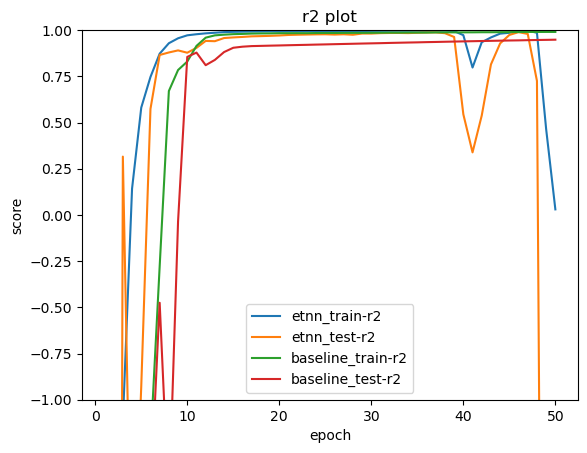

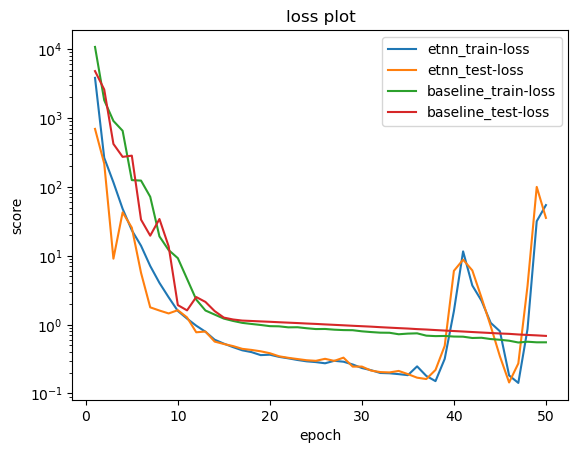

Rank 2 parameter configuration: Unnamed: 0                                      11
number                                          11
value                                     0.966222
datetime_start          2023-12-21 01:42:53.016540
datetime_complete       2023-12-21 01:45:00.400043
duration                    0 days 00:02:07.383503
params_batcher                                True
params_hidden_dim                              432
params_k                                         1
params_learning_rate                       0.00665
state                                     COMPLETE
Name: 11, dtype: object
Model params etnn: 498097


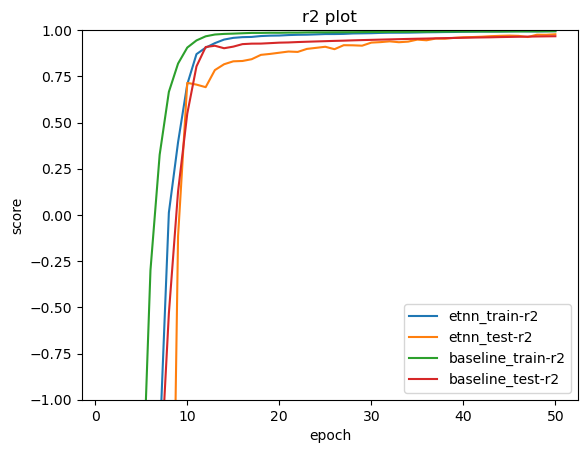

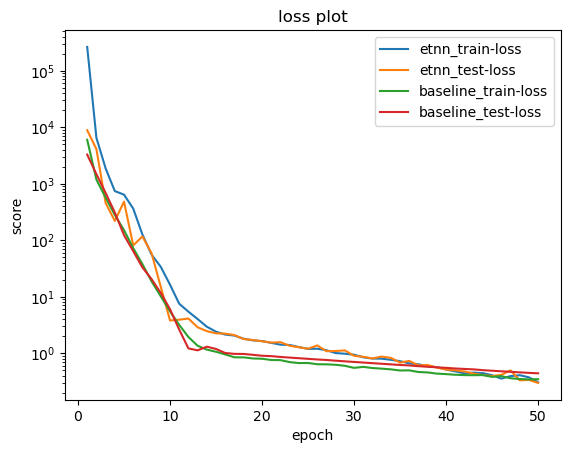

Rank 3 parameter configuration: Unnamed: 0                                      21
number                                          21
value                                     0.962607
datetime_start          2023-12-21 02:07:10.448223
datetime_complete       2023-12-21 02:09:18.369724
duration                    0 days 00:02:07.921501
params_batcher                                True
params_hidden_dim                              384
params_k                                         1
params_learning_rate                       0.00402
state                                     COMPLETE
Name: 21, dtype: object
Model params etnn: 394369


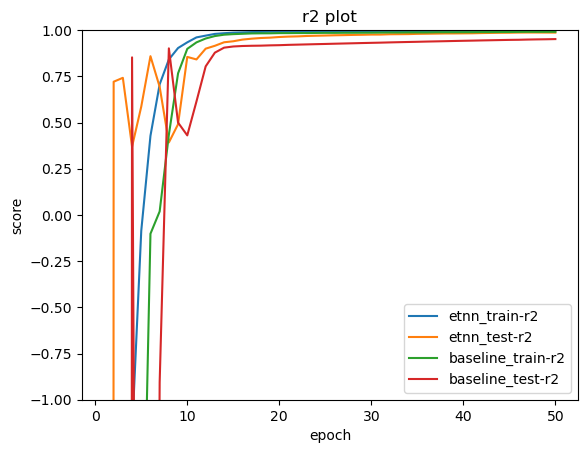

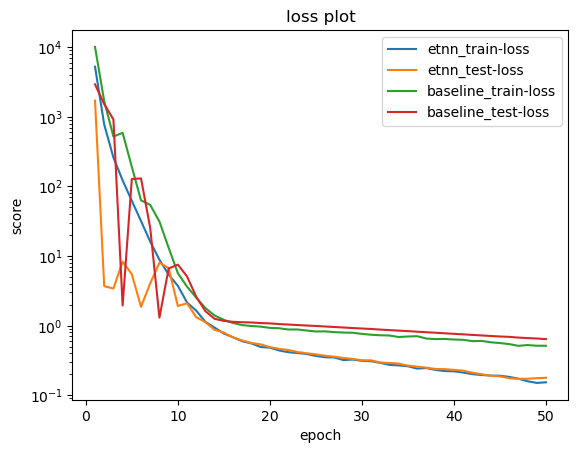

In [10]:
normalized = True
size_elem = 50
node_type = "C"

config_table = pd.read_csv(f"csvs/single-node_t-{node_type}_n-{size_elem}_normalized-{normalized}_s-{size_elem}.csv")

# sort config storage
config_table = config_table.sort_values(by=['value'], ascending=False)

# iterate over top 3 best configs
for i in range(3):
    # get entry from dataframe
    entry = config_table.iloc[i]

    # print information to console
    print(f"Rank {i+1} parameter configuration: {entry}")

    run(i, entry, size_elem, normalized, node_type)

# P

Rank 1 parameter configuration: Unnamed: 0                                      14
number                                          14
value                                     0.998964
datetime_start          2023-12-21 02:48:43.443773
datetime_complete       2023-12-21 02:51:13.850525
duration                    0 days 00:02:30.406752
params_batcher                                True
params_hidden_dim                              400
params_k                                         4
params_learning_rate                      0.000067
state                                     COMPLETE
Name: 14, dtype: object
Model params etnn: 427601


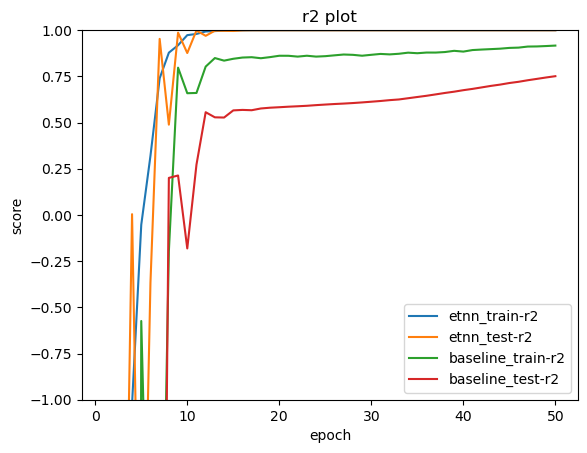

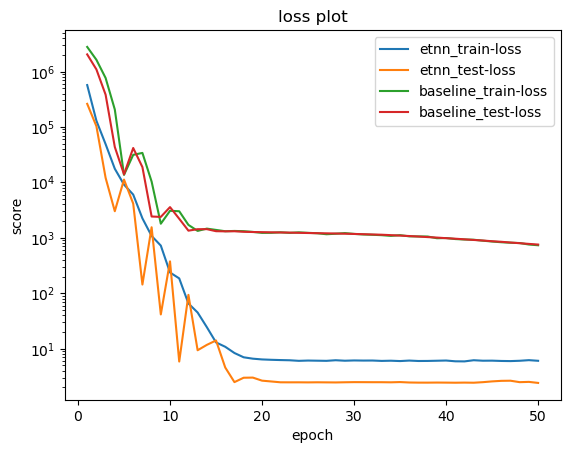

Rank 2 parameter configuration: Unnamed: 0                                      18
number                                          18
value                                      0.99854
datetime_start          2023-12-21 02:58:50.114333
datetime_complete       2023-12-21 03:01:20.446965
duration                    0 days 00:02:30.332632
params_batcher                               False
params_hidden_dim                              400
params_k                                         5
params_learning_rate                      0.000018
state                                     COMPLETE
Name: 18, dtype: object
Model params etnn: 427601


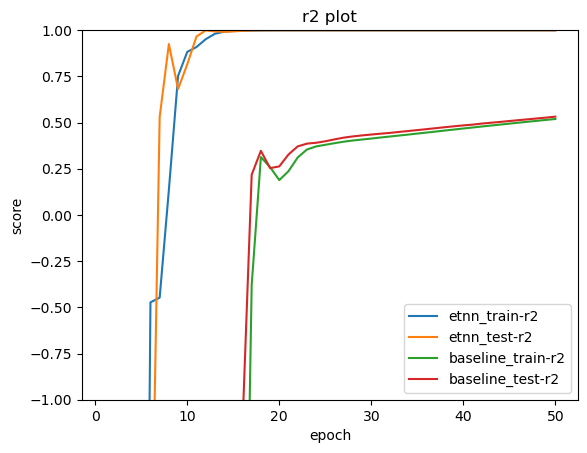

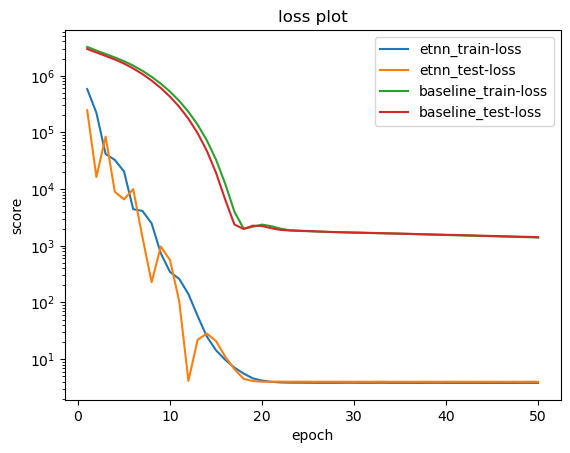

Rank 3 parameter configuration: Unnamed: 0                                      17
number                                          17
value                                     0.998377
datetime_start          2023-12-21 02:56:17.396309
datetime_complete       2023-12-21 02:58:50.113335
duration                    0 days 00:02:32.717026
params_batcher                                True
params_hidden_dim                              416
params_k                                         5
params_learning_rate                       0.00002
state                                     COMPLETE
Name: 17, dtype: object
Model params etnn: 462177


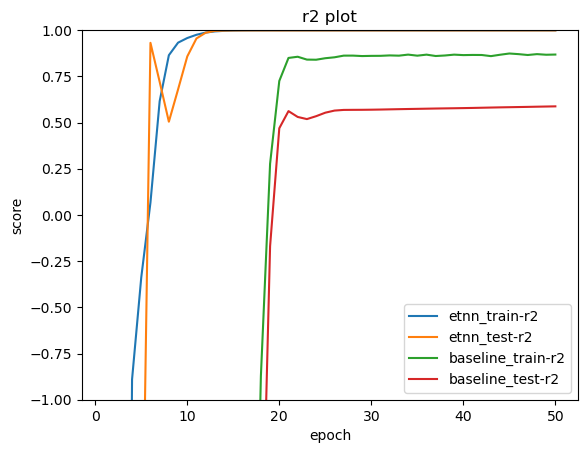

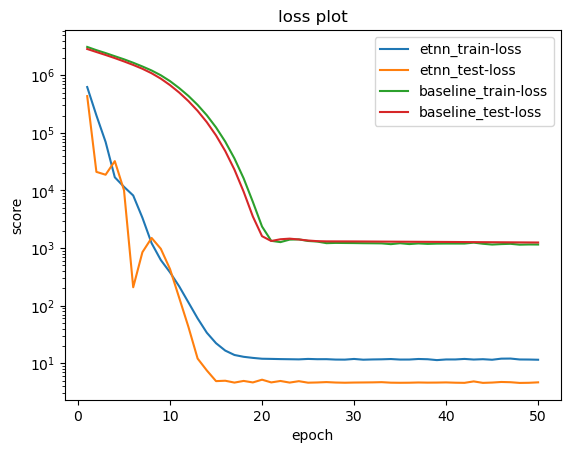

In [11]:
normalized = False
size_elem = 50
node_type = "P"

config_table = pd.read_csv(f"csvs/single-node_t-{node_type}_n-{size_elem}_normalized-{normalized}_s-{size_elem}.csv")

# sort config storage
config_table = config_table.sort_values(by=['value'], ascending=False)

# iterate over top 3 best configs
for i in range(3):
    # get entry from dataframe
    entry = config_table.iloc[i]

    # print information to console
    print(f"Rank {i+1} parameter configuration: {entry}")

    run(i, entry, size_elem, normalized, node_type)

Rank 1 parameter configuration: Unnamed: 0                                      23
number                                          23
value                                     0.901365
datetime_start          2023-12-21 04:07:17.623245
datetime_complete       2023-12-21 04:09:27.908571
duration                    0 days 00:02:10.285326
params_batcher                                True
params_hidden_dim                              336
params_k                                         4
params_learning_rate                      0.005789
state                                     COMPLETE
Name: 23, dtype: object
Model params etnn: 302737


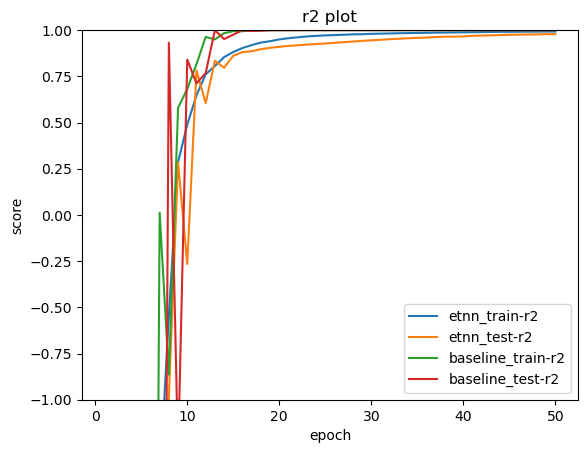

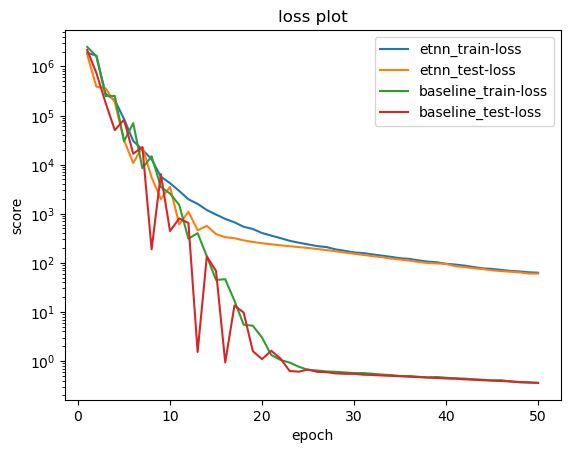

Rank 2 parameter configuration: Unnamed: 0                                      22
number                                          22
value                                     0.897783
datetime_start          2023-12-21 04:05:09.531914
datetime_complete       2023-12-21 04:07:17.622247
duration                    0 days 00:02:08.090333
params_batcher                                True
params_hidden_dim                              240
params_k                                         5
params_learning_rate                      0.004431
state                                     COMPLETE
Name: 22, dtype: object
Model params etnn: 155761


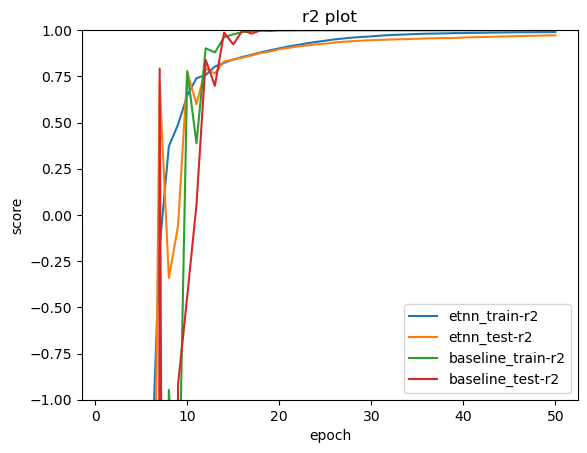

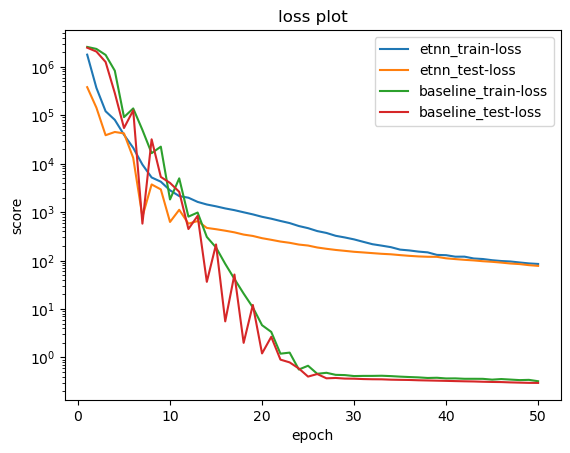

Rank 3 parameter configuration: Unnamed: 0                                      24
number                                          24
value                                      0.88536
datetime_start          2023-12-21 04:09:27.909570
datetime_complete       2023-12-21 04:11:35.514382
duration                    0 days 00:02:07.604812
params_batcher                                True
params_hidden_dim                              352
params_k                                         4
params_learning_rate                      0.009565
state                                     COMPLETE
Name: 24, dtype: object
Model params etnn: 331937


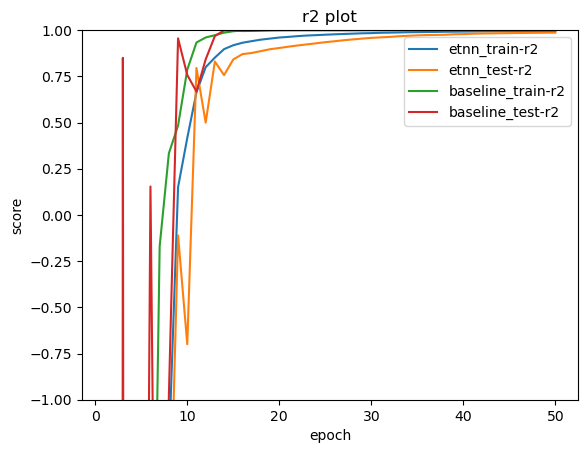

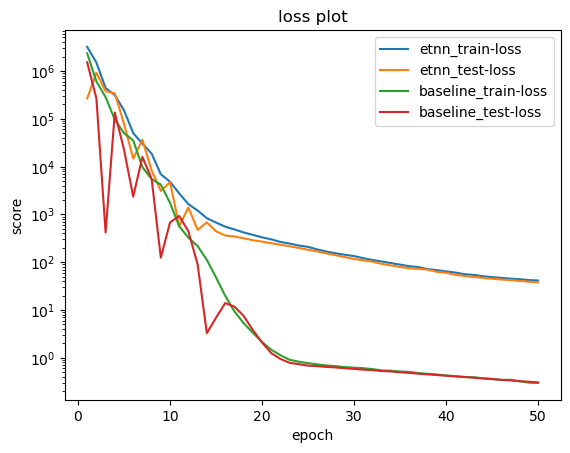

In [12]:
normalized = True
size_elem = 50
node_type = "P"

config_table = pd.read_csv(f"csvs/single-node_t-{node_type}_n-{size_elem}_normalized-{normalized}_s-{size_elem}.csv")

# sort config storage
config_table = config_table.sort_values(by=['value'], ascending=False)

# iterate over top 3 best configs
for i in range(3):
    # get entry from dataframe
    entry = config_table.iloc[i]

    # print information to console
    print(f"Rank {i+1} parameter configuration: {entry}")

    run(i, entry, size_elem, normalized, node_type)